# Modeling & Evaluation Overview

- This notebook focuses on building and evaluating machine learning models using the cleaned dataset prepared in the previous notebook.

- The objective is to predict the optimal BerthID for incoming vessels based on available pre-arrival features.

- Multiple models will be trained and compared using appropriate evaluation metrics.

# Load Cleaned Dataset

In [1]:
import pandas as pd

df = pd.read_csv(
    "/kaggle/input/vessel-berth-allocation-data-understanding-eda/df_clean.csv"
)

df.head()


,Terminal_Site_Key,Type,DurationInHours,DurationInMinutes,Service_ID,Service_Nm,BerthID,BerthCustomGrouping,VesselClass,LOA,...,TE_Hatch,TE_SBB,TE_SBTB,TE_Twin_Lift,Ship type,Gross Tonnage,Summer Deadweight (t),Length Overall (m),Beam (m),Berth_len
0,28,unknown,24.0,1440.0,gri,tilbury - west africa schedule,a,pq10,roro vessel,240.00,...,0.0,0.0,0.0,0.0,ro-ro cargo ship,71543.0,31340.0,236.0,36.0,266
1,28,unknown,24.0,1440.0,gri,tilbury - west africa schedule,b,pq12,roro vessel,240.00,...,0.0,0.0,0.0,0.0,ro-ro cargo ship,71543.0,31340.0,236.0,36.0,270
2,28,roro,47.0,2879.0,unknown,unknown,a,q24,other,236.32,...,0.0,0.0,0.0,0.0,ro-ro cargo ship,71543.0,31340.0,236.0,36.0,215
3,28,roro,23.0,1439.0,unknown,unknown,b,q24,other,236.32,...,0.0,0.0,0.0,0.0,ro-ro cargo ship,71543.0,31340.0,236.0,36.0,215
4,28,roro,23.0,1439.0,unknown,unknown,a,q24,other,236.32,...,0.0,0.0,0.0,0.0,ro-ro cargo ship,71543.0,31340.0,236.0,36.0,215


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Terminal_Site_Key      7022 non-null   int64  
 1   Type                   7022 non-null   object 
 2   DurationInHours        7022 non-null   float64
 3   DurationInMinutes      7022 non-null   float64
 4   Service_ID             7022 non-null   object 
 5   Service_Nm             7022 non-null   object 
 6   BerthID                7022 non-null   object 
 7   BerthCustomGrouping    7022 non-null   object 
 8   VesselClass            7022 non-null   object 
 9   LOA                    7022 non-null   float64
 10  CountryCode            7022 non-null   object 
 11  ShipOwnerGroup         7022 non-null   object 
 12  IsSpecificCall         7022 non-null   object 
 13  TE_TC20                7022 non-null   float64
 14  TE_TC40                7022 non-null   float64
 15  TE_D

# Target & Feature Separation

In [3]:
# Define target and features
X = df.drop(columns=["BerthID"])
y = df["BerthID"]

# Check shapes
X.shape, y.shape


((7022, 29), (7022,))

In [4]:
# Check target distribution
y.value_counts(normalize=True)


BerthID
b      0.250641
a      0.250071
q24    0.117203
q23    0.116918
q00    0.098547
q25    0.030333
q19    0.030048
qr1    0.028624
q22    0.028197
qw     0.027200
qr2    0.022216
Name: proportion, dtype: float64

# Train / Test Split

The dataset was split into training and testing sets using stratified sampling to preserve the original berth distribution across both sets.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((5617, 29), (1405, 29))

In [6]:
# Verify distribution preservation
y_train.value_counts(normalize=True)


BerthID
b      0.250668
a      0.250134
q24    0.117144
q23    0.116966
q00    0.098451
q25    0.030265
q19    0.030087
qr1    0.028663
q22    0.028129
qw     0.027239
qr2    0.022254
Name: proportion, dtype: float64

In [7]:
y_test.value_counts(normalize=True)

BerthID
b      0.250534
a      0.249822
q24    0.117438
q23    0.116726
q00    0.098932
q25    0.030605
q19    0.029893
q22    0.028470
qr1    0.028470
qw     0.027046
qr2    0.022064
Name: proportion, dtype: float64

# Preprocessing Pipeline

To ensure a clean and leakage-free modeling process, preprocessing steps were implemented using a unified pipeline.

- Numerical features are scaled to improve model convergence.
- Categorical features are encoded using One-Hot Encoding.
- All preprocessing steps are fit only on the training data and consistently applied to the test data.


In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline


In [9]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include="object").columns.tolist()
numerical_cols = X_train.select_dtypes(exclude="object").columns.tolist()

categorical_cols, numerical_cols


(['Type',
  'Service_ID',
  'Service_Nm',
  'BerthCustomGrouping',
  'VesselClass',
  'CountryCode',
  'ShipOwnerGroup',
  'IsSpecificCall',
  'Ship type'],
 ['Terminal_Site_Key',
  'DurationInHours',
  'DurationInMinutes',
  'LOA',
  'TE_TC20',
  'TE_TC40',
  'TE_DEBA',
  'TE_EMBA',
  'TE_DEBA_OOG',
  'TE_EMBA_OOG',
  'TE_GearBox',
  'TE_Hatch',
  'TE_SBB',
  'TE_SBTB',
  'TE_Twin_Lift',
  'Gross Tonnage',
  'Summer Deadweight (t)',
  'Length Overall (m)',
  'Beam (m)',
  'Berth_len'])

In [10]:
# Preprocessing for numerical features
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)


In [11]:
# Fit only on training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transform test data
X_test_processed = preprocessor.transform(X_test)

X_train_processed.shape, X_test_processed.shape


((5617, 161), (1405, 161))

# Baseline Models

Baseline models were trained to establish a reference performance level before applying more complex machine learning algorithms.


In [12]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(X_train_processed, y_train)
y_pred_dummy = dummy_clf.predict(X_test_processed)

print("Dummy Accuracy:", accuracy_score(y_test, y_pred_dummy))
print("Dummy Macro F1:", f1_score(y_test, y_pred_dummy, average="macro"))


Dummy Accuracy: 0.2505338078291815
Dummy Macro F1: 0.03642572566875356


The Dummy Classifier was used as a naive baseline to establish a minimum expected performance level.
Its results confirm that any meaningful model must significantly outperform random or majority-class predictions.


## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

log_reg.fit(X_train_processed, y_train)
y_pred_lr = log_reg.predict(X_test_processed)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Macro F1:", f1_score(y_test, y_pred_lr, average="macro"))


Logistic Regression Accuracy: 0.6740213523131673
Logistic Regression Macro F1: 0.6968998790449723


### Logistic Regression (Baseline Model)

Logistic Regression was trained as a strong baseline model using class weighting to handle class imbalance.
The model achieved a significant improvement over the Dummy Classifier, indicating that meaningful relationships between vessel characteristics and berth allocation were learned.


In [14]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

           a       0.48      0.49      0.49       351
           b       0.48      0.47      0.48       352
         q00       1.00      1.00      1.00       139
         q19       0.51      0.50      0.51        42
         q22       0.53      0.42      0.47        40
         q23       1.00      1.00      1.00       164
         q24       1.00      1.00      1.00       165
         q25       0.41      0.42      0.41        43
         qr1       1.00      1.00      1.00        40
         qr2       1.00      1.00      1.00        31
          qw       0.28      0.34      0.31        38

    accuracy                           0.67      1405
   macro avg       0.70      0.70      0.70      1405
weighted avg       0.68      0.67      0.67      1405



## Classification Report Analysis

The classification report provides a detailed view of model performance across all berth classes.
Macro F1-score was used as a key metric to ensure fair evaluation across both majority and minority classes in the presence of class imbalance.


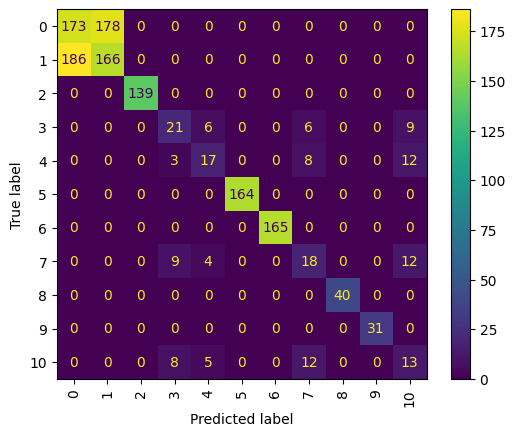

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=90)
plt.show()


## Confusion Matrix

- The confusion matrix illustrates how often the Logistic Regression model correctly predicts each berth and where misclassifications occur.

- Most predictions are concentrated along the diagonal, indicating strong performance for frequently used berths such as A and B.

- Misclassifications tend to occur between operationally similar berths, suggesting that non-linear models may further improve performance.

## Top-3 Accuracy

- Top-3 accuracy evaluates whether the true berth appears among the top three predicted berth candidates.
- This metric provides a more realistic assessment of model performance in operational berth allocation scenarios.


In [16]:
import numpy as np

# Predict class probabilities
y_proba = log_reg.predict_proba(X_test_processed)

# Get indices of top 3 predictions for each sample
top3_pred = np.argsort(y_proba, axis=1)[:, -3:]

# Calculate Top-3 accuracy
top3_accuracy = np.mean([
    y_test.iloc[i] in log_reg.classes_[top3_pred[i]]
    for i in range(len(y_test))
])

print("Top-3 Accuracy:", top3_accuracy)


Top-3 Accuracy: 0.9686832740213523


## Model Performance Summary

- The Logistic Regression model achieves a Top-1 accuracy of approximately 67%.

- More importantly, the Top-3 accuracy reaches nearly 97%, meaning that the true berth is almost always included among the top three predicted options.

- This highlights the model's strong suitability for real-world berth allocation, where providing multiple feasible berth candidates is often more valuable than a single hard prediction.


## Logistic Regression – Cross-Validation

To assess the stability of the Logistic Regression model across different data splits, stratified cross-validation was applied using the full preprocessing and modeling pipeline. Macro F1-score was used as the primary evaluation metric to account for class imbalance.


In [17]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

log_reg_cv = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    log_reg_cv,
    X,
    y,
    cv=cv,
    scoring="f1_macro"
)

print("CV Macro F1 scores:", cv_scores)
print("Mean CV Macro F1:", cv_scores.mean())


CV Macro F1 scores: [0.69768749 0.69079779 0.71446707 0.69616628 0.68493838]
Mean CV Macro F1: 0.6968114025949005


### Cross-Validation Interpretation

The cross-validation results are consistent with the test set performance, indicating that the Logistic Regression model provides stable and reliable baseline performance.

# Advanced Model

## Random Forest Classifier

To capture non-linear relationships between vessel characteristics and berth
allocation decisions, a Random Forest classifier was trained as an advanced
model. Random Forests are well-suited for handling complex interactions and
can better distinguish between operationally similar berths.


## Random Forest (Baseline)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

rf_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Macro F1:", f1_score(y_test, y_pred_rf, average="macro"))


Random Forest Accuracy: 0.6825622775800712
Random Forest Macro F1: 0.6879471431526488


In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           a       0.50      0.50      0.50       351
           b       0.51      0.51      0.51       352
         q00       1.00      1.00      1.00       139
         q19       0.47      0.43      0.45        42
         q22       0.36      0.35      0.35        40
         q23       1.00      1.00      1.00       164
         q24       1.00      1.00      1.00       165
         q25       0.44      0.44      0.44        43
         qr1       1.00      1.00      1.00        40
         qr2       1.00      1.00      1.00        31
          qw       0.30      0.32      0.31        38

    accuracy                           0.68      1405
   macro avg       0.69      0.69      0.69      1405
weighted avg       0.68      0.68      0.68      1405



## Random Forest – Classification Report Insights

- The Random Forest baseline model shows performance comparable to Logistic Regression,
  with slight improvements for certain less frequent berths.
- Overall gains are modest, suggesting that the baseline Random Forest configuration
  is not sufficient to significantly outperform the linear model.
- This behavior is expected given the high-dimensional one-hot encoded feature space,
  where tree-based models may require careful tuning to fully capture complex patterns.


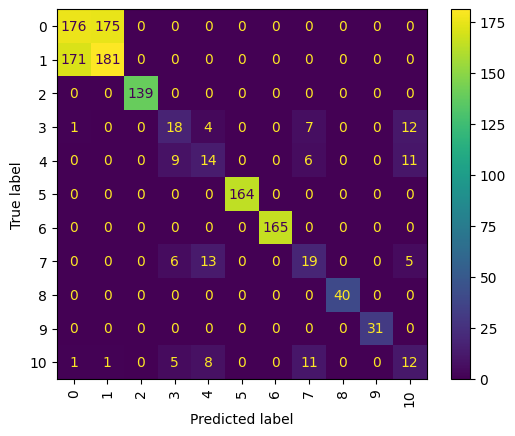

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot(xticks_rotation=90)
plt.show()


## Random Forest – Confusion Matrix Insights

- The confusion matrix shows that most misclassifications occur between
  operationally similar berths rather than random classes.
- Compared to Logistic Regression, the Random Forest model slightly reduces
  some off-diagonal errors but does not fully resolve confusion between
  major berths such as A and B.


## Top-3 Accuracy

In [21]:
import numpy as np

y_proba_rf = rf_clf.predict_proba(X_test)
top3_pred_rf = np.argsort(y_proba_rf, axis=1)[:, -3:]

top3_accuracy_rf = np.mean([
    y_test.iloc[i] in rf_clf.named_steps["model"].classes_[top3_pred_rf[i]]
    for i in range(len(y_test))
])

print("Random Forest Top-3 Accuracy:", top3_accuracy_rf)


Random Forest Top-3 Accuracy: 0.9651245551601424


## Random Forest – Top-3 Accuracy Interpretation

- The Random Forest model achieves a Top-3 accuracy of approximately 96.5%,
  which is comparable to the Logistic Regression baseline.
- This indicates that while the top-1 prediction does not significantly improve,
  the correct berth is still consistently included among the top candidate options.



### Random Forest – Final Assessment

The Random Forest model demonstrates performance comparable to Logistic Regression across accuracy, macro F1-score, and Top-3 accuracy. The confusion matrix reveals a similar pattern of misclassifications, particularly among operationally similar berths.

Given the lack of meaningful performance improvement and the increased model complexity, further hyperparameter tuning was not pursued.


## Final Model Selection

Two models were evaluated for the berth allocation task:
- Logistic Regression (baseline and interpretable model)
- Random Forest (advanced ensemble model)

While Random Forest provided competitive performance, Logistic Regression achieved comparable accuracy, macro F1-score, and top-3 accuracy with significantly lower complexity.

Given its simplicity, interpretability, and deployment readiness, Logistic Regression was selected as the final production model.


## Conclusion & Future Work

This project demonstrated the feasibility of predicting the most suitable berth for incoming vessels using pre-arrival vessel and service data.

The final model achieves strong classification performance while remaining lightweight and interpretable, making it suitable for real-world deployment.

Future improvements may include:
- Incorporating real-time port congestion data
- Exploring gradient boosting models under production constraints
- Continuous model retraining with newly arriving vessel data


In [22]:
import joblib

# Save preprocessor
joblib.dump(preprocessor, "preprocessor.pkl")

# Save final model
joblib.dump(log_reg, "logistic_regression_model.pkl")


['logistic_regression_model.pkl']

In [23]:
# Export 5 sample rows for API testing
sample_df = X.sample(5, random_state=42)

sample_df.to_csv("sample_input.csv", index=False)

sample_df


,Terminal_Site_Key,Type,DurationInHours,DurationInMinutes,Service_ID,Service_Nm,BerthCustomGrouping,VesselClass,LOA,CountryCode,...,TE_Hatch,TE_SBB,TE_SBTB,TE_Twin_Lift,Ship type,Gross Tonnage,Summer Deadweight (t),Length Overall (m),Beam (m),Berth_len
3909,6,mother vessel,47.0,2805.0,ea1,euraf1:hebdo1 europe afrique,q23,container vessel,267.0,cy,...,70.0,0.0,2.0,238.0,container ship,42382.0,52683.0,268.0,32.0,215
2462,28,mother vessel,29.0,1692.0,msc,nwc to/from morocco - west africa,pq12,container vessel,237.0,pa,...,34.0,0.0,0.0,372.0,container ship,37071.0,46600.0,237.0,32.0,270
2879,28,mother vessel,41.0,2436.0,ea5,europe afrique 5,pq01,container vessel,280.0,gb,...,44.0,0.0,36.0,608.0,container ship,49810.0,62234.0,280.0,32.0,250
3761,6,unknown,72.0,4320.0,wes,west med,p10,container vessel,260.0,pm,...,0.0,0.0,0.0,0.0,container ship,40631.0,56904.0,260.0,32.0,200
3745,6,mother vessel,115.0,6870.0,other,other,8,container vessel,249.0,mh,...,0.0,0.0,0.0,0.0,container ship,47911.0,55937.0,250.0,37.0,220


In [24]:
from joblib import dump
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

final_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

final_pipeline.fit(X_train, y_train)

dump(final_pipeline, "logistic_regression_pipeline.pkl")


['logistic_regression_pipeline.pkl']